In [91]:
from sympy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Heizkurve vor Sanierung
symbols https://de.overleaf.com/learn/latex/List_of_Greek_letters_and_math_symbols

tutorial https://docs.sympy.org/latest/explanation/best-practices.html

Im Buch beschriebene Vorgehensweise genutzt, um Heizkurve von unsanierten Fall zu ermitteln
Im nächsten Schritt (Excel) werden neue VLT, RLT und (mittlere) log. Übertemperatur für Sanierungen ermittelt, neues Q geht aus der SIM hervor.
Mit neuem Q, VLT, RLT & Übertemp. werden dann die Formeln erneut genutzt, um die Heizkurve für die Sanierungen zu ermitteln.

## Definieren der Symbole & Formeln

In [92]:
T_VN = Symbol('vartheta_V,N') # Norm-Vorlauftemperatur
# Define the remaining variables from the table
T_RN = Symbol('vartheta_R,N')  # Norm-Rücklauftemperatur
T_aN = Symbol('vartheta_a,N')  # Norm-Außentemperatur
T_i = Symbol('vartheta_i')  # Raumtemperatur
p = Symbol('p')  # Heizflächenexponent
delta_T_mN = Symbol('\\Delta \\vartheta_m,N')  # mittlere Übertemperatur Normzustand
phi = Symbol('varphi')  # Lastverhältnis (Kann aus Simulationsergebnissen entnommen werden)
x = Symbol('x')  # Hilfsgröße
theta_V = Symbol('\\vartheta_V')  # Vorlauftemperatur
T_a = Symbol('\\vartheta_a')  # Außentemperatur
T_aGrenz = Symbol('\\vartheta_{a,Grenz}')  # Grenz-Außentemperatur

## Definieren der Gleichungen

In [93]:
theta_R = theta_V - phi * (T_VN - T_RN)  # Rücklauftemperatur Gl. 5.11
theta_R

\vartheta_V - varphi*(-vartheta_R,N + vartheta_V,N)

In [94]:
theta_V =  (exp(x)*((T_VN - T_RN)*phi+T_i)-T_i)/(exp(x)-1) # Gl. 5.9
theta_V

(-vartheta_i + (varphi*(-vartheta_R,N + vartheta_V,N) + vartheta_i)*exp(x))/(exp(x) - 1)

In [95]:
x = (phi ** (p/(1+p)) * (T_VN - T_RN)) / delta_T_mN # Gl. 5.10
x

varphi**(p/(p + 1))*(-vartheta_R,N + vartheta_V,N)/\Delta \vartheta_m,N

In [96]:
phi = (T_aGrenz - T_a) / (T_aGrenz - T_aN) # Heizlastverhältnis Gl. 5.13
phi

(-\vartheta_a + \vartheta_{a,Grenz})/(\vartheta_{a,Grenz} - vartheta_a,N)

## Einsetzen der Formeln in einander, so dass nur noch $T_a$ als Variable übrig bleibt

In [97]:
# einsetzen von x in theta_V
phi = (T_aGrenz - T_a) / (T_aGrenz - T_aN)
x = (phi ** (p/(1+p)) * (T_VN - T_RN)) / delta_T_mN
theta_V =  (exp(x)*((T_VN - T_RN)*phi+T_i)-T_i)/(exp(x)-1)
theta_R = theta_V - phi * (T_VN - T_RN) 

In [98]:
print(latex(theta_V))

\frac{- \vartheta_{i} + \left(\vartheta_{i} + \frac{\left(- \vartheta_{a} + \vartheta_{a,Grenz}\right) \left(- \vartheta_{R,N} + \vartheta_{V,N}\right)}{\vartheta_{a,Grenz} - \vartheta_{a,N}}\right) e^{\frac{\left(\frac{- \vartheta_{a} + \vartheta_{a,Grenz}}{\vartheta_{a,Grenz} - \vartheta_{a,N}}\right)^{\frac{p}{p + 1}} \left(- \vartheta_{R,N} + \vartheta_{V,N}\right)}{\Delta \vartheta_{m,N}}}}{e^{\frac{\left(\frac{- \vartheta_{a} + \vartheta_{a,Grenz}}{\vartheta_{a,Grenz} - \vartheta_{a,N}}\right)^{\frac{p}{p + 1}} \left(- \vartheta_{R,N} + \vartheta_{V,N}\right)}{\Delta \vartheta_{m,N}}} - 1}


In [99]:
theta_V

(-vartheta_i + (vartheta_i + (-\vartheta_a + \vartheta_{a,Grenz})*(-vartheta_R,N + vartheta_V,N)/(\vartheta_{a,Grenz} - vartheta_a,N))*exp(((-\vartheta_a + \vartheta_{a,Grenz})/(\vartheta_{a,Grenz} - vartheta_a,N))**(p/(p + 1))*(-vartheta_R,N + vartheta_V,N)/\Delta \vartheta_m,N))/(exp(((-\vartheta_a + \vartheta_{a,Grenz})/(\vartheta_{a,Grenz} - vartheta_a,N))**(p/(p + 1))*(-vartheta_R,N + vartheta_V,N)/\Delta \vartheta_m,N) - 1)

## Ersetzen der Variablen durch tatsächliche Werte

In [100]:
def heizkurve(values):
    """ Erstellt die Heizkurve für die gegebenen Werte

    returns: Funktionen für $\\theta_V(T_a)$ und $\\theta_R(T_a)$
    """
    theta_V_subs = theta_V.subs(values)
    theta_R_subs = theta_R.subs(values)
    tehta_V_von_Ta = lambdify(T_a, theta_V_subs)
    tehta_R_von_Ta = lambdify(T_a, theta_R_subs)
    return tehta_V_von_Ta, tehta_R_von_Ta

# Define the values from the table
beispielfall = {
    T_VN:70,
    T_RN:50,
    T_aN:-15,
    T_i:20,
    p:0.3,
    delta_T_mN:39.15,
    T_aGrenz: 20
}
heizkurve_beispielfall = heizkurve(beispielfall)

# Erstellen der Heizkurven für alle Gebäude und Varianten
## Einlesen der Parameter

In [101]:
# Read the Excel file
file_path = r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_VL_RL_35_30_ueberarbeiten\9_2_FBH_Einfluss_optmimistisch.xlsx"
sheet_names = ['Output_Basis','Output_ambitioniert']
dfs = {}
for sheet_name in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet_name,header=1, index_col=0)
    df.name = df.index.name
    dfs[df.name] = df.T
    print(f"Sheet '{df.name}' has been read.")
    display(dfs[df.name])

Sheet 'Basis' has been read.


Basis,FVR,SB,SpS,TV
T_VN,39.200000,38.300000,37.300000,42.400000
T_RN,34.200000,33.300000,32.300000,37.400000
T_aN,-7.000000,-7.000000,-7.000000,-7.000000
T_i,21.000000,21.000000,21.000000,21.000000
p,0.000000,0.000000,0.000000,0.000000
delta_T_mN,11.316499,11.316499,11.316499,11.316499
T_aGrenz,21.000000,21.000000,21.000000,21.000000


Sheet 'Ambitioniert' has been read.


Ambitioniert,FVR,SB,SpS,TV
T_VN,35.000000,35.000000,35.000000,35.000000
T_RN,30.000000,30.000000,30.000000,30.000000
T_aN,-7.000000,-7.000000,-7.000000,-7.000000
T_i,21.000000,21.000000,21.000000,21.000000
p,0.000000,0.000000,0.000000,0.000000
delta_T_mN,11.316499,11.316499,11.316499,11.316499
T_aGrenz,21.000000,21.000000,21.000000,21.000000


## Berechnen der Heizkurven

In [102]:
heizkurven = {}
for variante in dfs:
    # each row is a building
    for gebaeude in dfs[variante]:
        values = dfs[variante][gebaeude]
        parameter = {
            T_VN: values['T_VN'],
            T_RN: values['T_RN'],
            T_aN: values['T_aN'],
            T_i: values['T_i'],
            p: values['p'],
            delta_T_mN: values['delta_T_mN'],
            T_aGrenz: values['T_aGrenz']
        }
        heizkurven[variante,gebaeude] = heizkurve(parameter)

# Heizkurven für ambitioniert in csv speichern
for variante,gebaeude in heizkurven:
    heizkurven[variante,gebaeude]
    df = pd.DataFrame({
        'T_a': np.arange(-20, 21, 1),
        'theta_V': heizkurven[variante,gebaeude][0](np.arange(-20, 21, 1)),
        'theta_R': heizkurven[variante,gebaeude][1](np.arange(-20, 21, 1))
    })
    df.to_csv(f'9_outputs\{variante}_{gebaeude}.csv', index=False)

<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
C:\Users\lbarnic\AppData\Local\Temp\ipykernel_4668\3533974700.py:25: SyntaxWarning: invalid escape sequence '\{'
  df.to_csv(f'9_outputs\{variante}_{gebaeude}.csv', index=False)


## Plot der Heizkurven

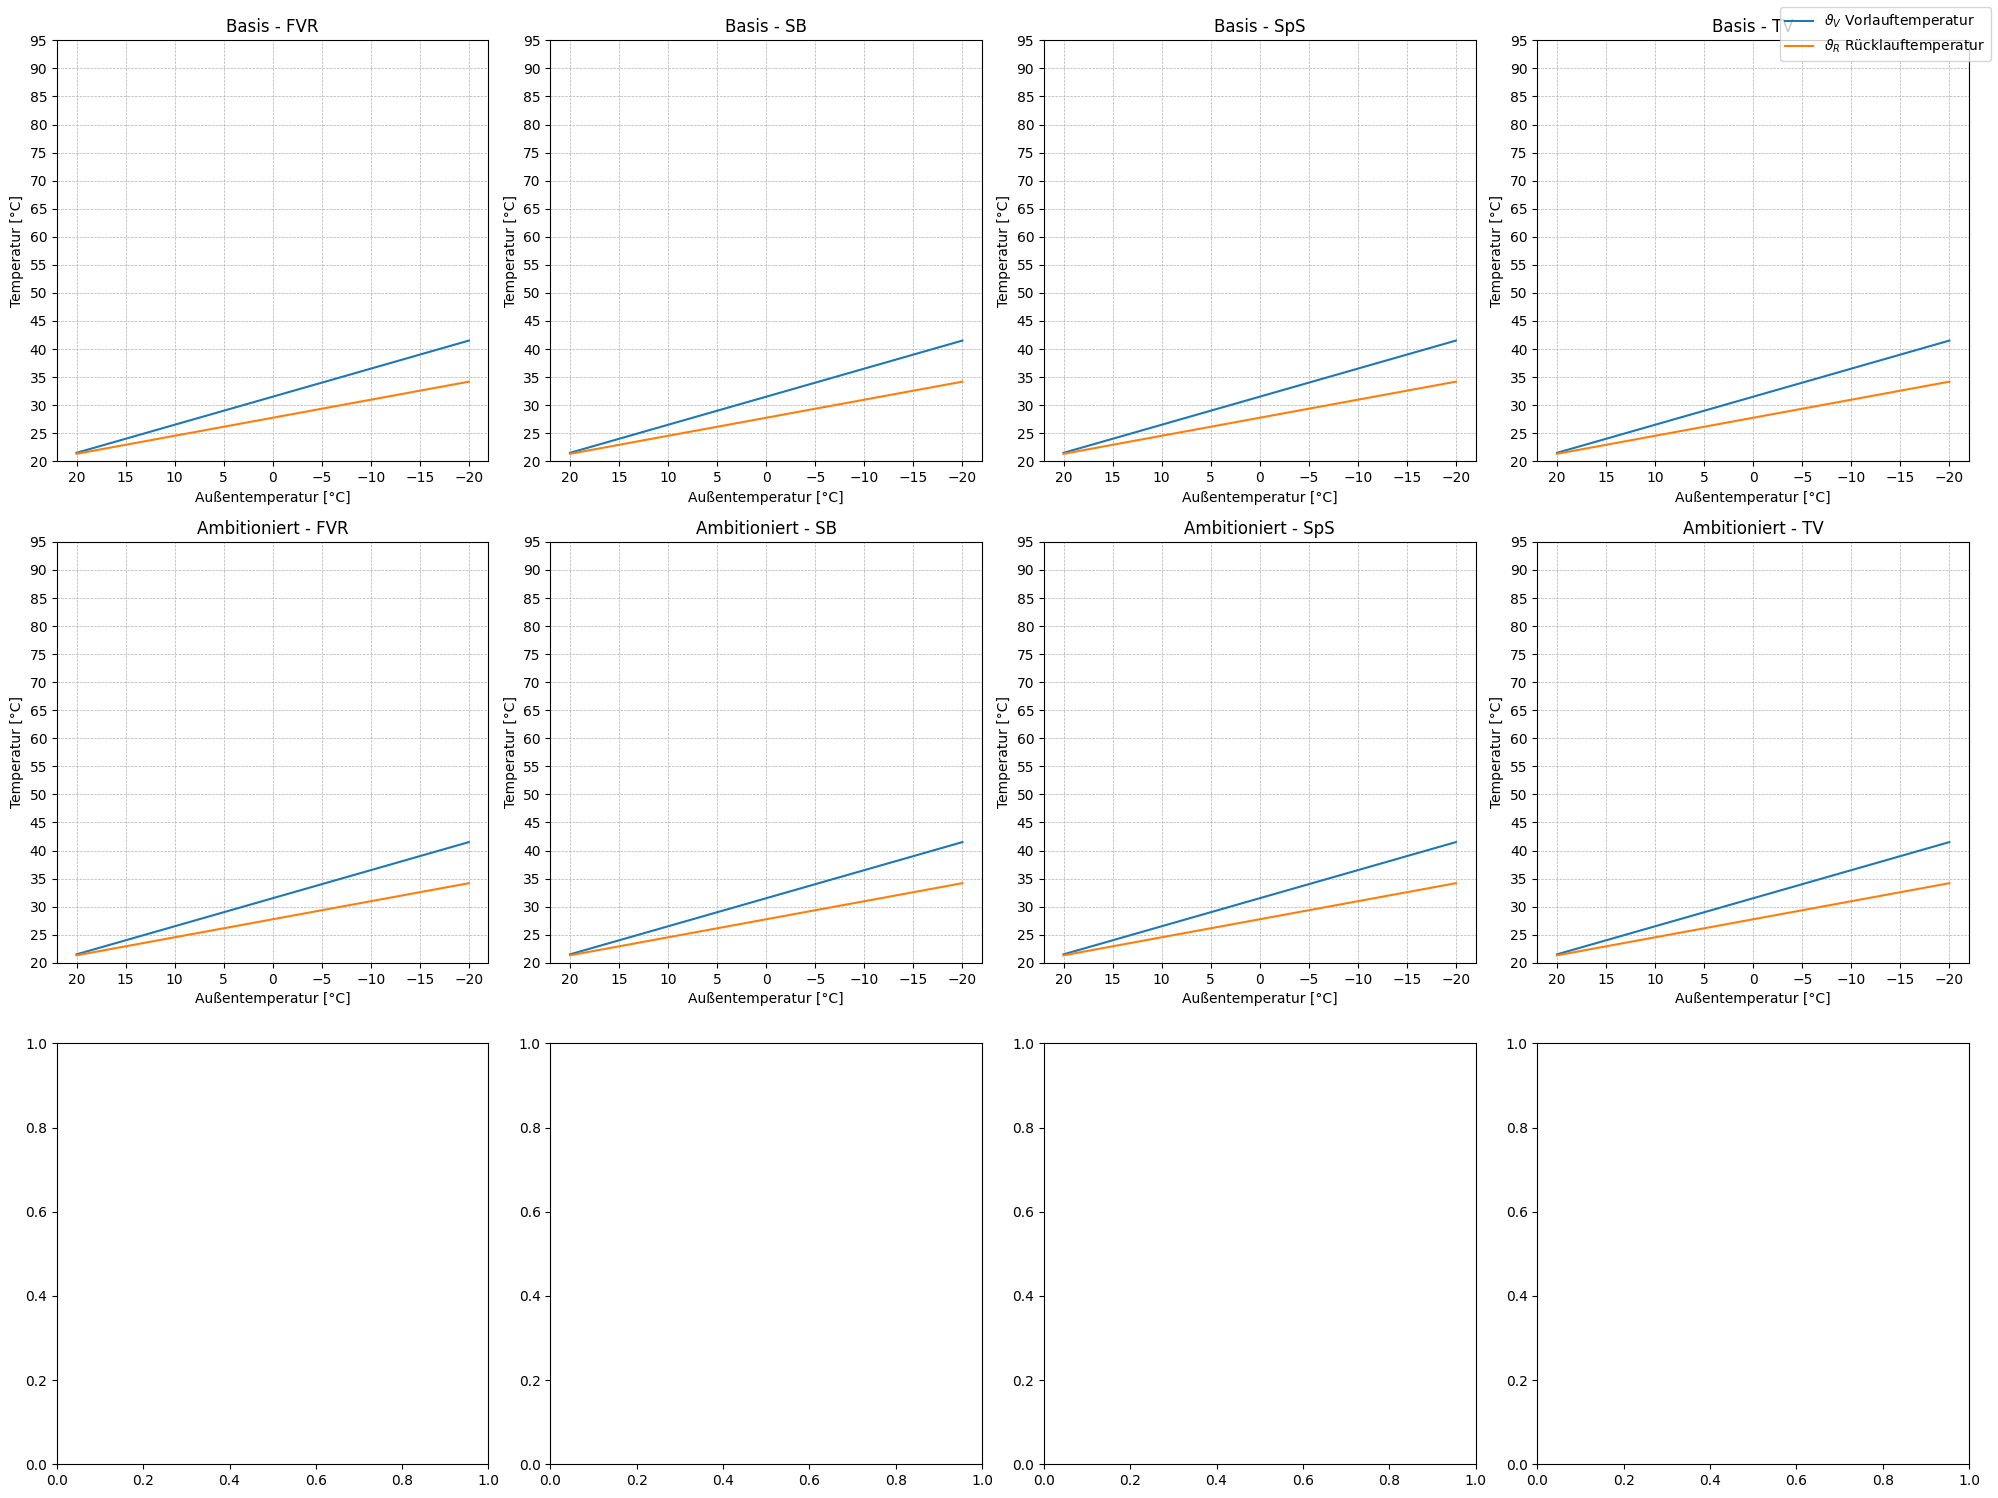

In [103]:
def plotHeizkurve(heizkurve,ax=None):
    T_a = np.linspace(-20, 20, 100)
    T_V, T_R = heizkurve
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(T_a, T_V(T_a))
    ax.plot(T_a, T_R(T_a))
    ax.set_xlabel('Außentemperatur [°C]')
    ax.set_ylabel('Temperatur [°C]')
    ax.invert_xaxis()
    ax.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    ax.set_xticks(np.arange(-20, 25, 5))
    ax.set_yticks(np.arange(20, 100, 5))

fig, axs = plt.subplots(3,4, figsize=(20,15), sharey=False)
for i, (variante, gebaeude) in enumerate(heizkurven):
    ax = axs.flatten()[i]
    plotHeizkurve(heizkurven[variante,gebaeude],ax=ax)
    ax.set_title(f"{variante} - {gebaeude}")
fig.legend(["$\\vartheta_V$ Vorlauftemperatur", "$\\vartheta_R$ Rücklauftemperatur"], loc='upper right')
plt.tight_layout()

In [104]:
# fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=False)
# for i, variante in enumerate(dfs):
#     ax = axs.flatten()[i]
#     for gebaeude in dfs[variante]:
#         T_V, T_R = heizkurven[variante,gebaeude]
#         T_a = np.linspace(-20, 20, 100)
#         ax.plot(T_a, T_V(T_a), label=gebaeude)
#     ax.set_title(variante)
#     ax.set_xlabel('Außentemperatur [°C]')
#     ax.set_ylabel('Temperatur [°C]')
#     ax.invert_xaxis()
#     ax.legend()
#     ax.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
#     ax.set_xticks(np.arange(-20, 25, 5))
#     ax.set_yticks(np.arange(20, 100, 5))

# fig.suptitle('Vorlauftemperatur')
# plt.tight_layout()

# # output data for each plot into a separate CSV file with multiple sheets
# with pd.ExcelWriter(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_VL_RL_35_30_ueberarbeiten\9_2_Output_optimistisch.xlsx") as writer:
#     for variante in dfs:
#         for gebaeude in dfs[variante]:
#             T_V, T_R = heizkurven[variante,gebaeude]
#             T_a = np.linspace(-20, 20, 100)
#             df = pd.DataFrame({
#                 'T_a': T_a,
#                 'theta_V': T_V(T_a),
#                 'theta_R': T_R(T_a)
#             })
#             df.to_excel(writer, sheet_name=f'{variante}_{gebaeude}', index=False)


In [105]:
# # Vorlauftemperaturen bei -7°C
# for variante in dfs:
#     for gebaeude in dfs[variante]:
#         T_V, T_R = heizkurven[variante,gebaeude]
#         print(f"{variante}_{gebaeude}: {T_V(-7)}")



------
# NT Wärmenetz Input Data
## Vorlauftermperatur WN für TRNSYS Basis NT

In [106]:
# #Auswahl schlechteste Heizkurve TV
# # #import data from T_amb.out file from path "C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\6_Gesamtsysteme_REP\TRNSYS\TRY2015_503413075920_Jahr.dat"
# path = "C:\\Users\\lbarnic\\OneDrive - Fraunhofer\\A_Bearbeitung\\6_Gesamtsysteme_REP\\TRNSYS\\T_amb.out"
# df = pd.read_csv(path, header=0, sep='\\s+', index_col=0, skipinitialspace=True)
# df.columns = ['T_amb']

# T_V_von_Ta, T_R_von_Ta = heizkurven["Basis","TV"]
# df["T_V"] = T_V_von_Ta(df["T_amb"])

# T_grenz = dfs["Basis"].loc["T_aGrenz","TV"]
# # fill nans with T_a,grenz
# df["T_V"] = df["T_V"].fillna(T_grenz)

# df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_Outputs\9_VLT_Basis_NT_TV.csv")
# # plot df["TV"]

# df.plot(y=["T_amb", "T_V"], secondary_y="T_V", figsize=(15,5))
# #maximaler Wert der Vorlauftemperatur
# print(df["T_V"].max())

## Vorlauftemperatur Basis alle Gebäude

In [107]:
#import data from T_amb.out file from path "C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\6_Gesamtsysteme_REP\TRNSYS\TRY2015_503413075920_Jahr.dat"
path = "C:\\Users\\lbarnic\\OneDrive - Fraunhofer\\A_Bearbeitung\\6_Gesamtsysteme_REP\\TRNSYS\\T_amb.out"
df = pd.read_csv(path, header=0, sep='\\s+', index_col=0, skipinitialspace=True)
df.columns = ['T_amb']

# HT T_R
selected = [('Basis', 'FVR'), ('Basis', 'SB'), ('Basis', 'SpS'), ('Basis', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"VLT_{gebaeude}"] = T_V_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"VLT_{gebaeude}"] = df[f"VLT_{gebaeude}"].fillna(T_grenz)


# #plot HT
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_VL_RL_35_30_ueberarbeiten\9_2_Outputs_optimistisch\9_VLT_Basis_NT_allbuildings_optimistisch.csv")
# df.plot(subplots=True,figsize=(15,15), title="HT")

## RLT Basis alle Gebäude

In [108]:
#import data from T_amb.out file from path "C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\6_Gesamtsysteme_REP\TRNSYS\TRY2015_503413075920_Jahr.dat"
path = "C:\\Users\\lbarnic\\OneDrive - Fraunhofer\\A_Bearbeitung\\6_Gesamtsysteme_REP\\TRNSYS\\T_amb.out"
df = pd.read_csv(path, header=0, sep='\\s+', index_col=0, skipinitialspace=True)
df.columns = ['T_amb']

# HT T_R
selected = [('Basis', 'FVR'), ('Basis', 'SB'), ('Basis', 'SpS'), ('Basis', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"RLT_{gebaeude}"] = T_R_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"RLT_{gebaeude}"] = df[f"RLT_{gebaeude}"].fillna(T_grenz)


# #plot HT
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_VL_RL_35_30_ueberarbeiten\9_2_Outputs_optimistisch\9_RLT_Basis_NT_allbuidlings_optimistisch.csv")
# df.plot(subplots=True,figsize=(15,15), title="HT")


------
# KT Wärmenetz + Dezentral Input Data
## Vorlauftermperatur für TRNSYS Ambitioniert

## Vorlauftemperatur KT + Dezentral all buildings

In [109]:
#NT T_R
selected = [('Ambitioniert', 'FVR'), ('Ambitioniert', 'SB'), ('Ambitioniert', 'SpS'), ('Ambitioniert', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"VLT_{gebaeude}"] = T_V_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"VLT_{gebaeude}"] = df[f"VLT_{gebaeude}"].fillna(T_grenz)

# #plot NT
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_VL_RL_35_30_ueberarbeiten\9_2_Outputs_optimistisch\9_VLT_Ambitioniert_allbuildings_optimistisch.csv")
# df.plot(subplots=True,figsize=(15,15), title="NT")


## Rücklauftemperatur KT + Dezentral all buildings

In [110]:

#NT T_R
selected = [('Ambitioniert', 'FVR'), ('Ambitioniert', 'SB'), ('Ambitioniert', 'SpS'), ('Ambitioniert', 'TV')]
for key in selected:
    variante, gebaeude = key
    T_V_von_Ta, T_R_von_Ta = heizkurven[key]
    df[f"RLT_{gebaeude}"] = T_R_von_Ta(df["T_amb"])
    T_grenz = dfs[variante].loc["T_aGrenz",gebaeude]
    # fill nans with T_a,grenz
    df[f"RLT_{gebaeude}"] = df[f"RLT_{gebaeude}"].fillna(T_grenz)

# #plot NT
df.to_csv(r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\9_Parameterstudie_REP\9_2_VLT_Variation\9_VL_RL_35_30_ueberarbeiten\9_2_Outputs_optimistisch\9_RLT_Ambitioniert_allbuidlings_optimistisch.csv")
# df.plot(subplots=True,figsize=(15,15), title="NT")

<Axes: xlabel='TIME'>

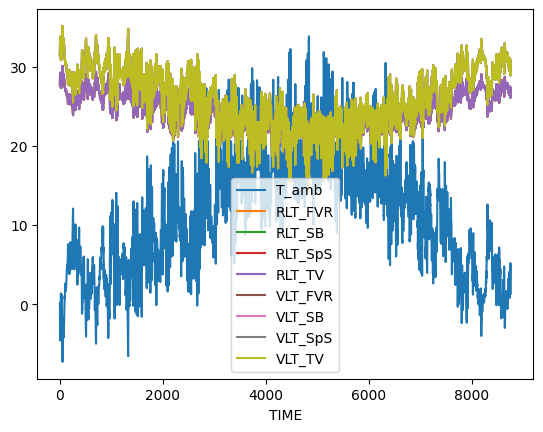

In [111]:
df.plot()

In [112]:
# mean temperature outside
df["T_amb"].mean()
# min temperatur outside und Zeitpunkt
df["T_amb"].min(), df["T_amb"].idxmin()



(np.float64(-7.287499999999999), np.float64(52.5))